In [1]:
!nvidia-smi

Fri Aug 18 10:27:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
! pip install -q transformers[sentencepiece] fastbook fastai ohmeow-blurr nbdev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import torch
import json
from transformers import AutoModelForSequenceClassification, AutoConfig
from fastai.text.all import *
from blurr.text.data.all import *
from blurr.text.modeling.all import *

/usr/local/lib/python3.10/dist-packages/blurr/text/modeling/question_answering.py:31: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  squad_metric = load_metric("squad")


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/New folder

/content/drive/MyDrive/New folder


In [7]:
df = pd.read_csv("final_details.csv")


In [8]:
df=df.drop_duplicates(subset=['url'])
df = df[df.types != '[]']
df.describe()

,title,url,description,types
count,18397,18397,18396,18397
unique,17332,18397,14719,17254
top,Paella,https://eatsmarter.com/recipes/cucumber-sandwiches-with-fresh-goat-cheese,30 mins,"['None', 'low-carb']"
freq,24,1,320,157


In [9]:
df = df.dropna().reset_index(drop=True)
df.shape

(18396, 4)

In [10]:
import ast

for i in range(len(df.types)):
  try:
    list_1 = ast.literal_eval(df.types[i])
    if isinstance(list_1, list):
      df.types[i] = list_1
  except (ValueError, SyntaxError):
    pass

In [11]:
 types_list = df.types.to_list()

In [12]:
mapping = {
    'Onion': 'Vegetable',
    'Poultry': 'Chicken',
    'saltwater\xa0Fish': 'saltwater fish',
    'Root Vegetable': 'Vegetable'
}

for sublist in types_list:
    for i in range(len(sublist)):
        sublist[i] = mapping.get(sublist[i], sublist[i])

types_list[1]

['Finger Food',
 'Low-cholesterol',
 'Fitness',
 'Healthy Eating',
 'Low-calorie',
 'Low-calorie Meat Dish',
 '250-400 Calorie',
 'low-carb',
 'non-alcoholic',
 'egg-free',
 'Pescetarian',
 'Special',
 '25-Minute',
 'Buffet',
 'Exotic',
 'Cooking on vacation',
 'festively',
 'Meal for Four',
 'Garden Party',
 'Guest',
 'Party',
 'Picnic',
 'Cooking',
 'Fish',
 'Vegetable',
 'leafy green vegetable',
 'Vegetable',
 'Herb',
 'Dairy',
 'Fruit',
 'Brunch',
 'Snack',
 'Party Snack',
 'Party Snack',
 'Tapas',
 'Appetizer']

In [13]:
for sublist in types_list:
    new_sublist = []
    for item in sublist:
        if item not in ['Party Snack','Pescetarian','Picnic','Garden Party','Party','Stomach Discomfort','everyday meal','Elevated Blood Lipid','Crohn&#039;s Disease','European','Course','Main Course''Meal for Four','Menu', 'Guest', 'Easy', 'Lactation', 'Quick','Cooking','Osteoarthritis','Stress','Iron Deficiency','Cooking on vacation','Pregnancy','Fertility']:
            new_sublist.append(item)
    sublist[:] = new_sublist
types_list[1]

['Finger Food',
 'Low-cholesterol',
 'Fitness',
 'Healthy Eating',
 'Low-calorie',
 'Low-calorie Meat Dish',
 '250-400 Calorie',
 'low-carb',
 'non-alcoholic',
 'egg-free',
 'Special',
 '25-Minute',
 'Buffet',
 'Exotic',
 'festively',
 'Meal for Four',
 'Fish',
 'Vegetable',
 'leafy green vegetable',
 'Vegetable',
 'Herb',
 'Dairy',
 'Fruit',
 'Brunch',
 'Snack',
 'Tapas',
 'Appetizer']

In [14]:
for i in range (len(types_list)):
  types_list[i]=types_list[i][:5]

types_list[1]

['Finger Food', 'Low-cholesterol', 'Fitness', 'Healthy Eating', 'Low-calorie']

In [15]:
for sublist in types_list:
    sublist[:] = list(set(sublist))
types_list[1]

['Healthy Eating', 'Finger Food', 'Low-calorie', 'Fitness', 'Low-cholesterol']

In [16]:
df.types=types_list

In [17]:
df

,title,url,description,types
0,Cucumber Sandwiches with Fresh Goat Cheese,https://eatsmarter.com/recipes/cucumber-sandwiches-with-fresh-goat-cheese,"Due to the high water content, the vegetables are very helpful for weight loss. 100 grams of cucumber provide just 12 calories. Cucumbers also contain potassium, iron, zinc, fluorine, and some vitamin C. With the goat's cheese comes satiating protein between the slices.","[Vegetable, low-carb, Cheese]"
1,Smoked Trout Tartare with Avocado Mango Salsa,https://eatsmarter.com/recipes/smoked-trout-tartare-with-avocado-mango-salsa,"The sulfur substances contained in chives are responsible for their slight pungency. They provide a slight antibacterial effect and have a positive effect on digestion. If things run smoothly in the intestines, our concentration is also ensured. This is also supported by the omega-3 fatty acids from the smoked salmon trout.","[Healthy Eating, Finger Food, Low-calorie, Fitness, Low-cholesterol]"
2,Basic Tofu Recipe,https://eatsmarter.com/recipes/basic-tofu-recipe,"Do you have a sensitive stomach? Then tofu is perfect for you, because it's easy on the stomach and doesn't put a strain on digestion. Great veggie option: With around 15 percent vegetable protein, soy cheese gives us about as much as most types of meat offer.","[Healthy Eating, High-protein, nutritional, Tofu, Low-cholesterol]"
3,Grilled Watermelon with Herbed Ricotta,https://eatsmarter.com/recipes/grilled-watermelon-with-herbed-ricotta,"Despite the fruity-sweet taste of Watermelons there is relatively little sugar in it. On top, the fruit provides plenty of liquid for a refreshing feast on hot summer days. Essential oils from Cress help to get disease-causing bacteria under control. For example, cold symptoms can subside more quickly.","[vegetarian grilling, Healthy Eating, nutritional, Gluten-free, Clean Eating]"
4,Egg Bites with Smoked Salmon and Broccoli,https://eatsmarter.com/recipes/egg-bites-with-smoked-salmon-and-broccoli,"Eggs contain a lot of biotin. This B vitamin promotes hair growth and a healthy nail bed. In addition, the substance is needed for all metabolic processes in the organism.","[Baking, pastry, nutritional, Gluten-free, muffin]"
...,...,...,...,...
18391,Sausage and Ham Croissants,https://eatsmarter.com/recipes/sausage-and-ham-croissants,Roll the dough on a lightly floured surface to 4-5 mm (approximately 1/8 inch) thick. Cut into 3 cm (approximately 1 1/4 inch) wide and 20 cm (approximately 8 inch) long strips.,"[Eggs, Quark-oil Dough, Milk, Breakfast, Pork]"
18392,Shakshuka with Eggplant,https://eatsmarter.com/recipes/shakshuka-with-eggplant,This delicious vegetable and egg shakshuka dish is packed with a slew of vitamins and minerals thanks to the vegetable mixture as well as powerful protein from the eggs. Shakshukas are versatile and are a complete meal,"[soul food, Eggs, baked dish, skillet vegetables, skillet dish]"
18393,Currant Jelly,https://eatsmarter.com/recipes/currant-jelly-1,"Remove the jelly from the pan, and place on a long platter. Serve with bread and cheese.","[Jelly, lactose-free, Gluten-free, Low-fat, Low-cholesterol]"
18394,Multi-Grain Walnut Bread,https://eatsmarter.com/recipes/multi-grain-walnut-bread,"Add both flours, the shredded wheat, ground walnuts and salt and knead with the dough hook until smooth. Cover and let rise in a warm place until doubled in bulk, about 45 minutes.","[Yeast Dough, Bread, Baking, Bread Dough, Rustic]"


In [18]:
types_list = df.types.to_list()
type_count = {}
for type1 in types_list:
  if isinstance(type1, list):
    type_list = type1
  else:
    type_list = eval(type1)
  for type2 in type_list:
    if type2 in type_count.keys():
      type_count[type2] += 1
    else:
      type_count[type2] = 1
print(f"Number of types: {len(type_count)}")
print(type_count)

Number of types: 987
{'Vegetable': 5059, 'low-carb': 2131, 'Cheese': 541, 'Healthy Eating': 871, 'Finger Food': 158, 'Low-calorie': 79, 'Fitness': 88, 'Low-cholesterol': 719, 'High-protein': 1005, 'nutritional': 959, 'Tofu': 65, 'vegetarian grilling': 16, 'Gluten-free': 566, 'Clean Eating': 834, 'Baking': 1261, 'pastry': 504, 'muffin': 77, 'Snack': 257, 'High-fiber Snack': 80, 'high-fiber': 1083, 'Vegan': 344, 'Snack for Kids': 14, 'High-fiber Soup': 79, 'diet': 1158, 'High-fiber Fish Dish': 99, 'Stew': 247, 'Breakfast': 136, 'Low Carb Diet': 55, 'low-carb lunch': 43, 'low-carb dinner': 53, 'Low-cholesterol Salad': 85, 'Alkaline': 19, 'cucumber salad': 28, 'Spring': 335, 'Fish': 1606, 'Spring Dish': 56, 'Paleo Diet': 294, 'Cooking technique': 17, 'High-fiber Vegetarian Dish': 481, 'Spread': 53, 'Beef': 463, 'Grandma&#039;s': 59, 'Beef Stroganoff': 4, 'Beef Ragout': 26, 'High-protein Fish Dish': 148, 'salad': 2066, 'Gluten-free Snack': 47, 'Eggs': 652, 'Gluten-free Vegetarian Recipe': 2

In [19]:
threshold = int(len(df) * 0.02)
rare_types = [key for key, value in type_count.items() if value < threshold]
len(rare_types), rare_types[:10]

(938,
 ['Finger Food',
  'Low-calorie',
  'Fitness',
  'Tofu',
  'vegetarian grilling',
  'muffin',
  'Snack',
  'High-fiber Snack',
  'Vegan',
  'Snack for Kids'])

In [20]:
types_list
revised_types_list = []
indices_to_drop = []

for idx, types in enumerate(types_list):
  if isinstance(types, list):
    type_list = types
  else:
    type_list = eval(types)

  revised_types = []

  for type1 in type_list:
    if type1 not in rare_types:
      revised_types.append(type1)

  if len(revised_types) == 0:
    indices_to_drop.append(idx)
  else:
    revised_types_list.append(revised_types)

df = df.drop(indices_to_drop).reset_index(drop=True)
df.shape

(17821, 4)

In [21]:
df['revised_types'] = revised_types_list

In [22]:
df.tail()

,title,url,description,types,revised_types
17816,Vegetable Scrambled Eggs on Rolls,https://eatsmarter.com/recipes/vegetable-scrambled-eggs-on-rolls,"Heat the margarine in a large skillet. Saute the pepper, onion and thyme. Add the zucchini and tomatoes and cook briefly. Pour in the beaten eggs and let the eggs thicken, occasionally stirring with a spatula to push the edges to the center.","[roll, Eggs, Vegetable, Breakfast, Scrambled Egg]","[Eggs, Vegetable]"
17817,Sausage and Ham Croissants,https://eatsmarter.com/recipes/sausage-and-ham-croissants,Roll the dough on a lightly floured surface to 4-5 mm (approximately 1/8 inch) thick. Cut into 3 cm (approximately 1 1/4 inch) wide and 20 cm (approximately 8 inch) long strips.,"[Eggs, Quark-oil Dough, Milk, Breakfast, Pork]",[Eggs]
17818,Shakshuka with Eggplant,https://eatsmarter.com/recipes/shakshuka-with-eggplant,This delicious vegetable and egg shakshuka dish is packed with a slew of vitamins and minerals thanks to the vegetable mixture as well as powerful protein from the eggs. Shakshukas are versatile and are a complete meal,"[soul food, Eggs, baked dish, skillet vegetables, skillet dish]","[Eggs, baked dish]"
17819,Currant Jelly,https://eatsmarter.com/recipes/currant-jelly-1,"Remove the jelly from the pan, and place on a long platter. Serve with bread and cheese.","[Jelly, lactose-free, Gluten-free, Low-fat, Low-cholesterol]","[Gluten-free, Low-cholesterol]"
17820,Multi-Grain Walnut Bread,https://eatsmarter.com/recipes/multi-grain-walnut-bread,"Add both flours, the shredded wheat, ground walnuts and salt and knead with the dough hook until smooth. Cover and let rise in a warm place until doubled in bulk, about 45 minutes.","[Yeast Dough, Bread, Baking, Bread Dough, Rustic]",[Baking]


In [23]:
revised_types_list = df.revised_types.to_list()
revised_types_list

[['Vegetable', 'low-carb', 'Cheese'],
 ['Healthy Eating', 'Low-cholesterol'],
 ['Healthy Eating', 'High-protein', 'nutritional', 'Low-cholesterol'],
 ['Healthy Eating', 'nutritional', 'Gluten-free', 'Clean Eating'],
 ['Baking', 'pastry', 'nutritional', 'Gluten-free'],
 ['nutritional', 'Clean Eating', 'high-fiber'],
 ['nutritional', 'low-carb', 'Clean Eating'],
 ['diet', 'high-fiber'],
 ['High-protein', 'diet', 'Gluten-free'],
 ['Healthy Eating', 'nutritional', 'low-carb'],
 ['Clean Eating', 'Low-cholesterol'],
 ['Fish', 'low-carb', 'Low-cholesterol'],
 ['diet', 'Fish', 'high-fiber'],
 ['nutritional', 'High-fiber Vegetarian Dish', 'Clean Eating', 'high-fiber'],
 ['nutritional', 'Gluten-free', 'Clean Eating', 'Low-cholesterol'],
 ['Beef', 'low-carb'],
 ['High-protein', 'nutritional', 'salad', 'Clean Eating'],
 ['Eggs', 'nutritional', 'Gluten-free'],
 ['Fish', 'Low-cholesterol'],
 ['high-fiber', 'Fish', 'Low-cholesterol'],
 ['Healthy Eating', 'Clean Eating'],
 ['High-protein', 'nutritiona

In [24]:
revised_types_list
revised_type_count = {}
for types in revised_types_list:
  type_list = types
  for type1 in type_list:
    if type1 in revised_type_count.keys():
      revised_type_count[type1] += 1
    else:
      revised_type_count[type1] = 1
print(f"Number of types: {len(revised_type_count)}")
print(revised_type_count)

Number of types: 49
{'Vegetable': 5059, 'low-carb': 2131, 'Cheese': 541, 'Healthy Eating': 871, 'Low-cholesterol': 719, 'High-protein': 1005, 'nutritional': 959, 'Gluten-free': 566, 'Clean Eating': 834, 'Baking': 1261, 'pastry': 504, 'high-fiber': 1083, 'diet': 1158, 'Fish': 1606, 'High-fiber Vegetarian Dish': 481, 'Beef': 463, 'salad': 2066, 'Eggs': 652, 'Vegetarian': 743, 'fruit-vegetable': 2156, 'saltwater fish': 1054, 'Vegetable Salad': 845, 'flowering vegetables': 469, 'Meat': 1858, 'Sauce': 489, 'Asian': 821, 'Chicken': 1349, 'Dessert': 1477, 'Herb': 1709, 'baked dish': 772, 'Roast': 821, 'Legume': 507, 'Shrimp': 564, 'Italian': 719, 'soup': 537, 'Seafood': 549, 'non-alcoholic': 433, 'Casserole': 612, 'mushroom': 408, 'Spices': 1054, 'leafy green vegetable': 559, 'Sprout': 544, 'Fruit': 1101, 'Tropical Fruit': 453, 'Dough': 1901, 'Pome Fruit': 462, 'Pasta': 2271, 'Rice': 1344, 'Fruit Dessert': 368}


In [25]:
revised_type_count.keys()

dict_keys(['Vegetable', 'low-carb', 'Cheese', 'Healthy Eating', 'Low-cholesterol', 'High-protein', 'nutritional', 'Gluten-free', 'Clean Eating', 'Baking', 'pastry', 'high-fiber', 'diet', 'Fish', 'High-fiber Vegetarian Dish', 'Beef', 'salad', 'Eggs', 'Vegetarian', 'fruit-vegetable', 'saltwater fish', 'Vegetable Salad', 'flowering vegetables', 'Meat', 'Sauce', 'Asian', 'Chicken', 'Dessert', 'Herb', 'baked dish', 'Roast', 'Legume', 'Shrimp', 'Italian', 'soup', 'Seafood', 'non-alcoholic', 'Casserole', 'mushroom', 'Spices', 'leafy green vegetable', 'Sprout', 'Fruit', 'Tropical Fruit', 'Dough', 'Pome Fruit', 'Pasta', 'Rice', 'Fruit Dessert'])

In [26]:
encode_types = { key: idx for idx, (key, value) in enumerate(revised_type_count.items())}
with open("recipe_types_encoded.json", "w") as fp:
  json.dump(encode_types, fp)

In [27]:
categorical_type_list = []
revised_types_list

for type5 in revised_types_list:
  categorical_list = [0] * len(encode_types)
  for type1 in type5:
    type1_index = encode_types[type1]
    categorical_list[type1_index] = 1
  categorical_type_list.append(categorical_list)

categorical_type_list[3][:45]

[0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [28]:
df['type_cat_list'] = categorical_type_list
df.head()

,title,url,description,types,revised_types,type_cat_list
0,Cucumber Sandwiches with Fresh Goat Cheese,https://eatsmarter.com/recipes/cucumber-sandwiches-with-fresh-goat-cheese,"Due to the high water content, the vegetables are very helpful for weight loss. 100 grams of cucumber provide just 12 calories. Cucumbers also contain potassium, iron, zinc, fluorine, and some vitamin C. With the goat's cheese comes satiating protein between the slices.","[Vegetable, low-carb, Cheese]","[Vegetable, low-carb, Cheese]","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,Smoked Trout Tartare with Avocado Mango Salsa,https://eatsmarter.com/recipes/smoked-trout-tartare-with-avocado-mango-salsa,"The sulfur substances contained in chives are responsible for their slight pungency. They provide a slight antibacterial effect and have a positive effect on digestion. If things run smoothly in the intestines, our concentration is also ensured. This is also supported by the omega-3 fatty acids from the smoked salmon trout.","[Healthy Eating, Finger Food, Low-calorie, Fitness, Low-cholesterol]","[Healthy Eating, Low-cholesterol]","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,Basic Tofu Recipe,https://eatsmarter.com/recipes/basic-tofu-recipe,"Do you have a sensitive stomach? Then tofu is perfect for you, because it's easy on the stomach and doesn't put a strain on digestion. Great veggie option: With around 15 percent vegetable protein, soy cheese gives us about as much as most types of meat offer.","[Healthy Eating, High-protein, nutritional, Tofu, Low-cholesterol]","[Healthy Eating, High-protein, nutritional, Low-cholesterol]","[0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,Grilled Watermelon with Herbed Ricotta,https://eatsmarter.com/recipes/grilled-watermelon-with-herbed-ricotta,"Despite the fruity-sweet taste of Watermelons there is relatively little sugar in it. On top, the fruit provides plenty of liquid for a refreshing feast on hot summer days. Essential oils from Cress help to get disease-causing bacteria under control. For example, cold symptoms can subside more quickly.","[vegetarian grilling, Healthy Eating, nutritional, Gluten-free, Clean Eating]","[Healthy Eating, nutritional, Gluten-free, Clean Eating]","[0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,Egg Bites with Smoked Salmon and Broccoli,https://eatsmarter.com/recipes/egg-bites-with-smoked-salmon-and-broccoli,"Eggs contain a lot of biotin. This B vitamin promotes hair growth and a healthy nail bed. In addition, the substance is needed for all metabolic processes in the organism.","[Baking, pastry, nutritional, Gluten-free, muffin]","[Baking, pastry, nutritional, Gluten-free]","[0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [29]:
labels = list(encode_types.keys())

In [30]:
model_name = "distilroberta-base"
model_cls = AutoModelForSequenceClassification
config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(labels)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(model_name, model_cls=model_cls, config=config)
hf_model.config.problem_type = "multi_label_classification"

In [31]:
blocks = (TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), MultiCategoryBlock(encoded=True,vocab=labels))
dblock = DataBlock(blocks=blocks, get_x=ColReader('description'), get_y=ColReader('type_cat_list'), splitter=RandomSplitter(valid_pct=0.1, seed=42))

In [32]:
dls = dblock.dataloaders(df, bs=32)
torch.save(dls, "/content/drive/MyDrive/New folder/dls-multilabel-recipe-classifier.pkl")

In [33]:
dls.vocab

['Vegetable', 'low-carb', 'Cheese', 'Healthy Eating', 'Low-cholesterol', 'High-protein', 'nutritional', 'Gluten-free', 'Clean Eating', 'Baking', 'pastry', 'high-fiber', 'diet', 'Fish', 'High-fiber Vegetarian Dish', 'Beef', 'salad', 'Eggs', 'Vegetarian', 'fruit-vegetable', 'saltwater fish', 'Vegetable Salad', 'flowering vegetables', 'Meat', 'Sauce', 'Asian', 'Chicken', 'Dessert', 'Herb', 'baked dish', 'Roast', 'Legume', 'Shrimp', 'Italian', 'soup', 'Seafood', 'non-alcoholic', 'Casserole', 'mushroom', 'Spices', 'leafy green vegetable', 'Sprout', 'Fruit', 'Tropical Fruit', 'Dough', 'Pome Fruit', 'Pasta', 'Rice', 'Fruit Dessert']

In [34]:
dls.show_batch(dataloaders=dls, max_n=10, trunc_at=256)

,text,target
0,"Rinse and trim zucchini, eggplant and bell peppers. Cut zucchini and eggplant into thin slices. Cut bell peppers in half, put on a baking sheet lined with parchment paper and toast under a preheated oven grill until skin begins to bubble and starts to tur","[baked dish, Casserole]"
1,"Mix flour in a large bowl, create a well in center, add crumbled yeast to well and sprinkle with sugar. Pour in about 50 ml (approximately 1/4 cup) water. Mix ingredients in well into a paste-like dough. Cover and let rest for 15 minutes in a warm place.",[Dough]
2,"For the filling, soak the bread in water. Peel the onion, finely dice and cook until translucent in 1 tablespoon butter. Squeeze the bread well, pick apart and mix with the minced meat, sausage meat, cooked onion, parsley and egg. Season with salt, pepper","[Dough, Pasta]"
3,"For the salad, peel the cucumber and avocado. The cut the cucumber in half lengthwise and remove the seeds. Cut the cucumber and avocado flesh into small cubes or 1/2 cm (approximately 1/2 inch) thick slices and place in the marinade, then let them marina","[Vegetable, Fish, salad, saltwater fish]"
4,"For the omelets, separate 2 eggs (save the 2 egg whites for another use). Beat egg yolks with the milk, add a pinch of salt and mix in the chopped herbs. Beat egg whites with a pinch of salt until stiff and fold into the batter. Heat some butter in a pan","[Gluten-free, Vegetarian]"
5,"Halve cucumber lengthwise, remove seeds and cut 1 cm (approximately1/2 inch) strips lengthwise. For the rice seasoning, boil together vinegar, sugar, 1 teaspoon salt and kombu and then strain. Pour cooked rice into a bowl and fold carefully with the marin","[Asian, Rice]"
6,"For the filling: Rinse the fennel, remove the fronds and set aside. Thinly slice the bulb and place in a bowl with the vinegar and oil and toss to coat. Rinse the radicchio, cut into thin strips and add to the bowl with the fennel. Peel the carrots and cu","[Vegetarian, non-alcoholic]"
7,"Rinse the fish, pat dry and cut into bite-size pieces. Clean the mussels and discard any that opened. Loosen the half of the mussels from the shell and keep the rest as a garnish for the paella. Peel the onion and the garlic, finely chop. Rinse the tomato",[High-protein]
8,Warm the milk and butter in a pan over low heat. Separate filo sheets and sprinkle with water. Cover with a damp cloth. Line a greased dish with a sheet of dough so that the dough hangs over the edge. Brush with the milk-butter mixture. Cut dough sheets i,"[Vegetable, Cheese, Eggs, Herb, Spices]"
9,"Also soak the chickpeas overnight, then cook in simmering salted water about 45 minutes. Blanch the green beans, plunge into salt water and drain. Rinse the peppers, cut in half, trim and cut into very thin strips. Peel the onion and finely chop. Add the",[Fish]


In [35]:
model = BaseModelWrapper(hf_model)

acc_02 = partial(accuracy_multi, thresh=0.5)

learner = Learner(dls,
                  model,
                  opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
                  loss_func=BCEWithLogitsLossFlat(),
                  metrics=[acc_02],
                  cbs=[BaseModelCallback],
                  splitter=blurr_splitter
                  ).to_fp16()

In [36]:
learner.freeze()

SuggestedLRs(slide=0.0008317637839354575, valley=0.00015848931798245758)

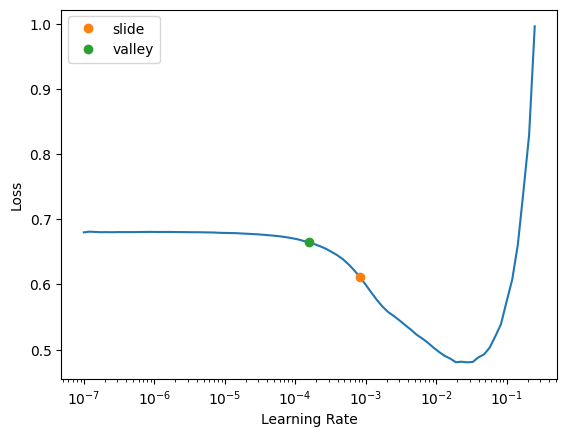

In [37]:
learner.lr_find(suggest_funcs=[slide, valley])

In [38]:
learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.186399,0.177058,0.943826,00:43
1,0.173564,0.171370,0.944421,00:36
2,0.177560,0.166066,0.945555,00:36
3,0.167813,0.162939,0.946059,00:39
4,0.161324,0.162479,0.946300,00:37


In [39]:
learner.save("recipe-classifier-stage-1")

Path('models/recipe-classifier-stage-1.pth')

In [40]:
learner.export("/content/drive/MyDrive/New folder/recipe-classifier-stage-1.pkl")

SuggestedLRs(slide=0.0004786300996784121, valley=9.120108734350652e-05)

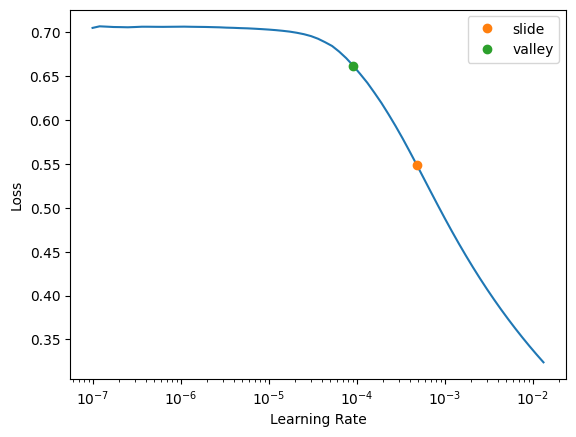

In [ ]:
learner.unfreeze()
learner.lr_find(suggest_funcs=[slide, valley])

In [ ]:
learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.000595,0.000285,1.000000,01:02
1,0.000075,0.000064,1.000000,01:08
2,0.000038,0.000035,1.000000,01:02
3,0.000029,0.000027,1.000000,01:03
4,0.000027,0.000026,1.000000,00:53


In [ ]:
learner.save("recipe-classifier-stage-9")

In [ ]:
learner.export("/content/drive/MyDrive/New folder/models/recipe-classifier-stage-9.pkl")